In [14]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
PLAYER_STATS = pd.read_json('PLAYER_STATS.json', orient='records', lines=True)

### Preparing to Build Model: Checking Feature Correlation

In [9]:
# Drop ID columns for correlation matrix
PLAYER_STATS_CORR = PLAYER_STATS.drop(columns=['BATTER_ID', 'ID'])

In [10]:
correlation_matrix = PLAYER_STATS_CORR.corr()

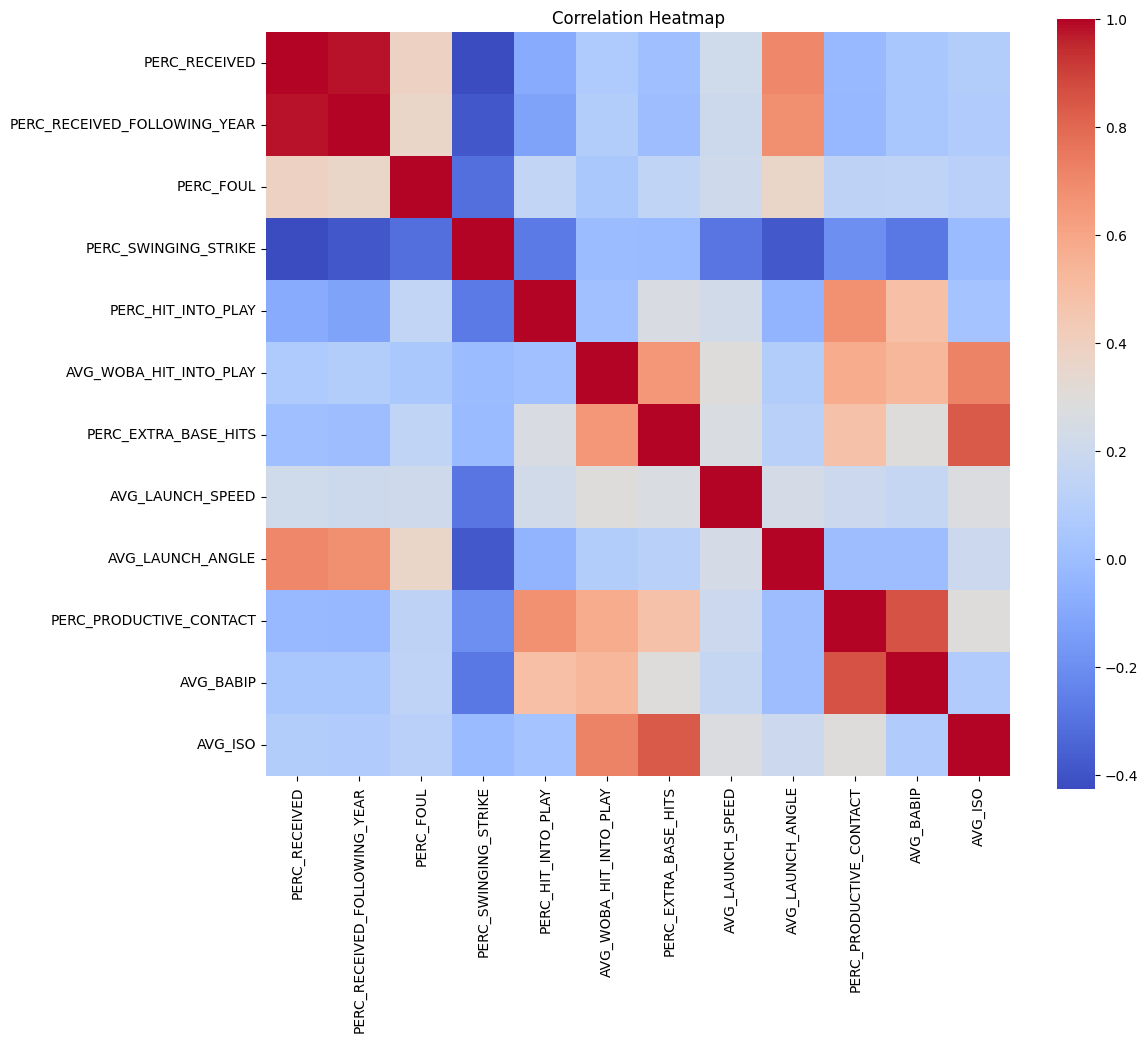

In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
threshold = 0.75
# boolean mask where correlation values are above the threshold and not equal to 1
high_corr = (correlation_matrix > threshold) & (correlation_matrix < 1.0)

# Display the pairs of variables that have correlation above the threshold
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if high_corr.loc[row, col]:
            print(f"Correlation between {row} and {col}: {correlation_matrix.loc[row, col]:.3f}")

Correlation between PERC_RECEIVED_FOLLOWING_YEAR and PERC_RECEIVED: 0.979
Correlation between PERC_RECEIVED and PERC_RECEIVED_FOLLOWING_YEAR: 0.979
Correlation between AVG_ISO and PERC_EXTRA_BASE_HITS: 0.834
Correlation between AVG_BABIP and PERC_PRODUCTIVE_CONTACT: 0.858
Correlation between PERC_PRODUCTIVE_CONTACT and AVG_BABIP: 0.858
Correlation between PERC_EXTRA_BASE_HITS and AVG_ISO: 0.834


**Will not include PERC_PRODUCTIVE_CONTACT and PERC_EXTRA_BASE_HITS as features because closely correlated with BABIP and ISO**

In [17]:
PLAYER_STATS.keys()

Index(['BATTER_ID', 'ID', 'PERC_RECEIVED', 'PERC_RECEIVED_FOLLOWING_YEAR',
       'PERC_FOUL', 'PERC_SWINGING_STRIKE', 'PERC_HIT_INTO_PLAY',
       'AVG_WOBA_HIT_INTO_PLAY', 'PERC_EXTRA_BASE_HITS', 'AVG_LAUNCH_SPEED',
       'AVG_LAUNCH_ANGLE', 'PERC_PRODUCTIVE_CONTACT', 'AVG_BABIP', 'AVG_ISO'],
      dtype='object')

### Prepare Data to Train Models

In [18]:
train_data = PLAYER_STATS[~PLAYER_STATS['ID'].str.contains('2023', na=False)]
train_data = train_data.dropna(subset=['PERC_RECEIVED_FOLLOWING_YEAR'])
train_data = train_data.dropna(subset=['PERC_RECEIVED'])

In [20]:
# Add pitch type categorical variable
def determine_pitch_type(player_id):
    if 'OS' in player_id:
        return 'OS'
    elif 'BB' in player_id:
        return 'BB'  
    elif 'FB' in player_id:
        return 'FB' 

train_data['PITCH_TYPE'] = train_data['ID'].apply(determine_pitch_type)
train_data['PITCH_TYPE'] = train_data['PITCH_TYPE'].astype('category')

In [21]:
features = [
      'PERC_RECEIVED', 'PERC_FOUL','PERC_SWINGING_STRIKE', 'PERC_HIT_INTO_PLAY', 'AVG_WOBA_HIT_INTO_PLAY',
      'AVG_LAUNCH_SPEED', 'AVG_LAUNCH_ANGLE', 'AVG_BABIP', 'AVG_ISO', 'PITCH_TYPE'
      ]

In [22]:
X = train_data[features]
X = pd.get_dummies(X, columns=['PITCH_TYPE'], drop_first=True) # one hot encoding to turn pitch type into binary
y = train_data['PERC_RECEIVED_FOLLOWING_YEAR']  # Target variable

### Train Model Random Forest - not used for predictions

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
predictions = model.predict(X_test)

In [26]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'MAE: {mae}, MSE: {mse}, R²: {r2}')


MAE: 2.400267715354343, MSE: 9.898237686459746, R²: 0.968060887779675


In [27]:
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(scores)  # Check how well it performs across multiple folds


[0.58442113 0.87971623 0.37941865 0.90630837 0.43637481]


[0.0363556  0.00332575 0.00363682 0.00319815 0.00266054 0.00353943
 0.00365621 0.00276223 0.002808   0.77585876 0.16219851]


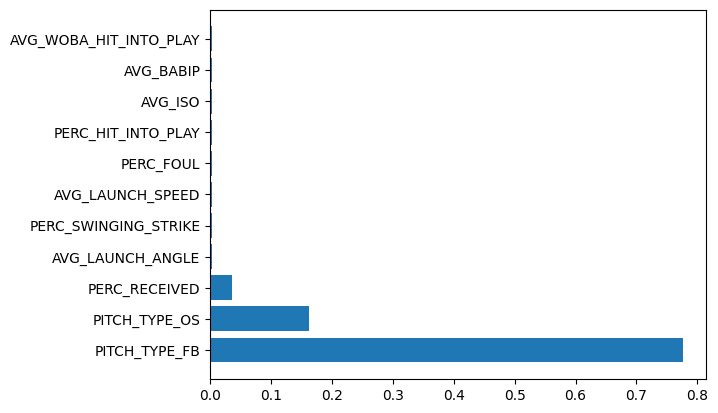

In [29]:
import numpy as np
importances = model.feature_importances_
print(importances)
indices = np.argsort(importances)[::-1]
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), [X_train.columns[i] for i in indices])
plt.show()

### Train Linear Regression Model - This model ended up performing better and is used for predictions

In [31]:
# Check for NaNs
print(X_train[X_train.isna().any(axis=1)])

Empty DataFrame
Columns: [PERC_RECEIVED, PERC_FOUL, PERC_SWINGING_STRIKE, PERC_HIT_INTO_PLAY, AVG_WOBA_HIT_INTO_PLAY, AVG_LAUNCH_SPEED, AVG_LAUNCH_ANGLE, AVG_BABIP, AVG_ISO, PITCH_TYPE_FB, PITCH_TYPE_OS]
Index: []


In [32]:
# Drop rows with NaN values (no longer necessary bc dealt with NaNs)
X_train_clean = X_train.dropna()
y_train_clean = y_train[X_train_clean.index]  # Ensure corresponding rows in y are also dropped

X_test_clean = X_test.dropna()
y_test_clean = y_test[X_test_clean.index]  # Ensure corresponding rows in y are also dropped


In [34]:
print(len(X_train_clean))
print(len(y_train_clean))

1154
1154


In [35]:
from sklearn.linear_model import LinearRegression

# Initialize the model
lin_model = LinearRegression()
# Fit the model on the training data
lin_model.fit(X_train_clean, y_train_clean)
# Predict on the test set
y_pred = lin_model.predict(X_test_clean)


In [36]:
# Mean Absolute Error
mae = mean_absolute_error(y_test_clean, y_pred)

# Mean Squared Error
mse = mean_squared_error(y_test_clean, y_pred)

# R-squared Score
r2 = r2_score(y_test_clean, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')


MAE: 2.4281559314008643
MSE: 10.61824866822908
R²: 0.9657375942525802


In [37]:
cv_scores = cross_val_score(lin_model, X_train_clean, y_train_clean, cv=5, scoring='r2')

print(f'Cross-Validation R² Scores: {cv_scores}')
print(f'Mean Cross-Validation R²: {cv_scores.mean()}')


Cross-Validation R² Scores: [0.96862469 0.97282335 0.96458531 0.96085885 0.96418751]
Mean Cross-Validation R²: 0.9662159398611051


**Understand Importance of Each Feature**

                   Feature  Coefficient
9            PITCH_TYPE_FB     8.970546
10           PITCH_TYPE_OS    -6.959894
8                  AVG_ISO    -2.871339
4   AVG_WOBA_HIT_INTO_PLAY     0.813828
0            PERC_RECEIVED     0.608904
7                AVG_BABIP    -0.257085
1                PERC_FOUL    -0.075467
5         AVG_LAUNCH_SPEED     0.035505
3       PERC_HIT_INTO_PLAY    -0.013877
2     PERC_SWINGING_STRIKE     0.006902
6         AVG_LAUNCH_ANGLE     0.000052


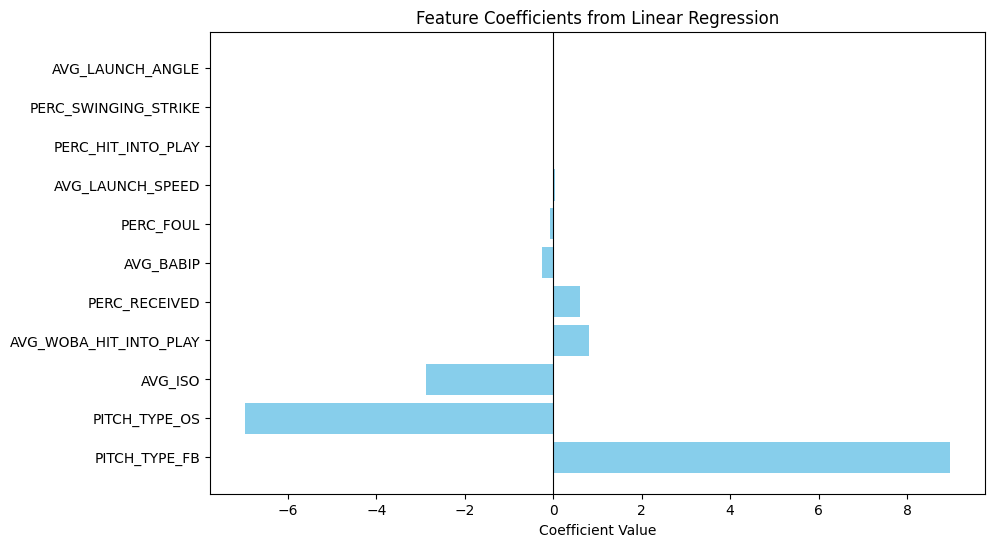

In [39]:
coefficients = lin_model.coef_

# Create a DataFrame for better visualization
coef_df = pd.DataFrame({
    'Feature': X_train_clean.columns,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of coefficients
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Print the coefficients
print(coef_df[['Feature', 'Coefficient']])

# Optionally, if you'd like to plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients from Linear Regression')
plt.axvline(0, color='black', linewidth=0.8)  # Add a vertical line at 0 for reference
plt.show()


## MAKE PREDICTIONS FOR 2024 (using lin_model)

In [41]:
import pandas as pd
import numpy as np

# Load the predictions DataFrame
predictions_df = pd.read_csv('predictions.csv')

# Load player stats dataframes for each pitch type and year from JSON files
PLAYER_STATS_FB_2023 = pd.read_json('PLAYER_STATS_FB_2023.json', lines=True)
PLAYER_STATS_BB_2023 = pd.read_json('PLAYER_STATS_BB_2023.json', lines=True)
PLAYER_STATS_OS_2023 = pd.read_json('PLAYER_STATS_OS_2023.json', lines=True)

PLAYER_STATS_FB_2022 = pd.read_json('PLAYER_STATS_FB_2022.json', lines=True)
PLAYER_STATS_BB_2022 = pd.read_json('PLAYER_STATS_BB_2022.json', lines=True)
PLAYER_STATS_OS_2022 = pd.read_json('PLAYER_STATS_OS_2022.json', lines=True)

PLAYER_STATS_FB_2021 = pd.read_json('PLAYER_STATS_FB_2021.json', lines=True)
PLAYER_STATS_BB_2021 = pd.read_json('PLAYER_STATS_BB_2021.json', lines=True)
PLAYER_STATS_OS_2021 = pd.read_json('PLAYER_STATS_OS_2021.json', lines=True)


player_stats = {
    'FB': [PLAYER_STATS_FB_2023, PLAYER_STATS_FB_2022, PLAYER_STATS_FB_2021],
    'BB': [PLAYER_STATS_BB_2023, PLAYER_STATS_BB_2022, PLAYER_STATS_BB_2021],
    'OS': [PLAYER_STATS_OS_2023, PLAYER_STATS_OS_2022, PLAYER_STATS_OS_2021]
}

def predict_pitch_types(batter_id, pitch_type):
    # Initialize PITCH_TYPE_FB and PITCH_TYPE_OS as boolean values
    pitch_type_fb = False
    pitch_type_os = False

    # Set the pitch type features based on the input pitch_type
    if pitch_type == 'FB':
        pitch_type_fb = True
    elif pitch_type == 'OS':
        pitch_type_os = True

    # Loop through each year in reverse order (2023 to 2021)
    for player_stats_df in player_stats[pitch_type]:
        player_stats_filtered = player_stats_df[player_stats_df['BATTER_ID'] == batter_id]

        # Check if the player stats dataframe is not empty
        if not player_stats_filtered.empty:
            # Extract features
            features = player_stats_filtered[['PERC_RECEIVED', 'PERC_FOUL', 'PERC_SWINGING_STRIKE',
                                               'PERC_HIT_INTO_PLAY', 'AVG_WOBA_HIT_INTO_PLAY',
                                               'AVG_LAUNCH_SPEED', 'AVG_LAUNCH_ANGLE', 'AVG_BABIP', 
                                               'AVG_ISO']].values
            
            # Create a new features array that includes PITCH_TYPE_FB and PITCH_TYPE_OS as booleans
            features_with_pitch_type = np.append(features, [[pitch_type_fb, pitch_type_os]], axis=1)
            
            # Make the prediction
            return lin_model.predict(features_with_pitch_type)[0]  # Use the trained model to predict

    return None  # No stats found for this player

In [42]:
import warnings
warnings.filterwarnings("ignore")

# Iterate over each batter in the predictions df and make prediction
for index, row in predictions_df.iterrows():
    batter_id = row['BATTER_ID']
    
    # Predict for each pitch type
    predictions_df.at[index, 'PITCH_TYPE_FB'] = predict_pitch_types(batter_id, 'FB')
    predictions_df.at[index, 'PITCH_TYPE_BB'] = predict_pitch_types(batter_id, 'BB')
    predictions_df.at[index, 'PITCH_TYPE_OS'] = predict_pitch_types(batter_id, 'OS')

# Save the updated DataFrame with predictions
predictions_df.to_csv('predicted_pitch_types5.csv', index=False)


#### Normalize the Predicted Percentages so they Sum to 100%

In [119]:
df = pd.read_csv('predicted_pitch_types5.csv')

df[['PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS']] = df[['PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS']].div(
    df[['PITCH_TYPE_FB', 'PITCH_TYPE_BB', 'PITCH_TYPE_OS']].sum(axis=1), axis=0) * 100

df.to_csv('predictions.csv', index=False)

# Scratch Work Below

#### Target Var is multimodel, maybe causing issues, this led to creation of categorical pitch type features

/Users/alipuccio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


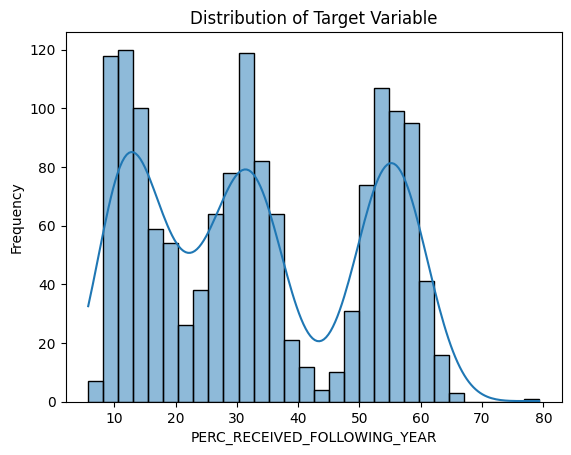

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('PERC_RECEIVED_FOLLOWING_YEAR')
plt.ylabel('Frequency')
plt.show()


#### Code to create a CSV that has predictions and the years the pitch data are from (some players not in 2023 df)

In [117]:
def predict_pitch_types(batter_id, pitch_type):
    pitch_type_fb = False
    pitch_type_os = False

    if pitch_type == 'FB':
        pitch_type_fb = True
    elif pitch_type == 'OS':
        pitch_type_os = True

    # Mapping of DataFrame indices to years (2023, 2022, 2021)
    year_mapping = {0: 2023, 1: 2022, 2: 2021}

    # Loop through each year in reverse order (2023 to 2021)
    for idx, player_stats_df in enumerate(player_stats[pitch_type]):
        player_stats_filtered = player_stats_df[player_stats_df['BATTER_ID'] == batter_id]

        if not player_stats_filtered.empty:
            # Extract features
            features = player_stats_filtered[['PERC_RECEIVED', 'PERC_FOUL', 'PERC_SWINGING_STRIKE',
                                               'PERC_HIT_INTO_PLAY', 'AVG_WOBA_HIT_INTO_PLAY',
                                               'AVG_LAUNCH_SPEED', 'AVG_LAUNCH_ANGLE', 'AVG_BABIP', 
                                               'AVG_ISO']].values
            
            # Create a new features array that includes PITCH_TYPE_FB and PITCH_TYPE_OS as booleans
            features_with_pitch_type = np.append(features, [[pitch_type_fb, pitch_type_os]], axis=1)
            
            # Make the prediction
            prediction = lin_model.predict(features_with_pitch_type)[0]  # Use the trained model to predict
            
            # Get the year based on the index and return it with the prediction
            year = year_mapping[idx]
            return prediction, year

    return None, None  # No stats found for this player


# Iterate over each batter in the predictions df and make predictions
for index, row in predictions_df.iterrows():
    batter_id = row['BATTER_ID']
    
    # Predict for each pitch type and retrieve both prediction and year
    prediction_fb, year_fb = predict_pitch_types(batter_id, 'FB')
    prediction_bb, year_bb = predict_pitch_types(batter_id, 'BB')
    prediction_os, year_os = predict_pitch_types(batter_id, 'OS')

    # Update DataFrame with predictions and year for each pitch type
    predictions_df.at[index, 'PITCH_TYPE_FB'] = prediction_fb
    predictions_df.at[index, 'PITCH_TYPE_BB'] = prediction_bb
    predictions_df.at[index, 'PITCH_TYPE_OS'] = prediction_os

    # Assign the year associated with each pitch type prediction
    predictions_df.at[index, 'PREDICTED_BASED_ON_YEAR_FB'] = year_fb
    predictions_df.at[index, 'PREDICTED_BASED_ON_YEAR_BB'] = year_bb
    predictions_df.at[index, 'PREDICTED_BASED_ON_YEAR_OS'] = year_os

# Save the updated DataFrame with predictions and years
predictions_df.to_csv('predicted_pitch_types_with_years.csv', index=False)
